<a href="https://colab.research.google.com/github/IvanMGro/montecarlo/blob/main/random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Montecarlo Random Walk


Haremos uso del método de montecarlo para realizar simulaciones aleatorias de precios del spot price de henry hub con el fin de obtener un valor promedio y los valores de los quantiles. Los quantiles se utilizan a menudo para evaluar el riesgo en una amplia de aplicaciones, como las finanzas, la ingeniería nuclear y en servicios industriales.

## Henry Hub Data

Haremos uso de las siguientes librerías

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

Descargamos datos del índice Henry Hub (```hh```) desde el año 2000, datos proveninentes de Energy Information Administration (EIA)


In [13]:
hh = pd.read_excel('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDd.xls',
                   sheet_name='Data 1',
                   skiprows=752, #Aqui inicia el año 2000
                   names=['date','price'],
                   index_col=0)
hh.describe()

,price
count,5537.000000
mean,4.402007
std,2.188150
min,1.330000
25%,2.850000
50%,3.800000
75%,5.490000
max,23.860000


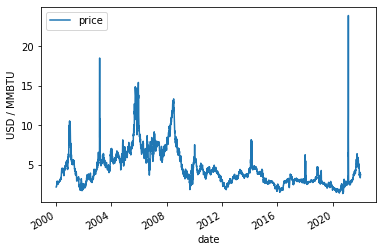

In [14]:
hh.plot(ylabel= 'USD / MMBTU')

Podemos visualizar la distribución de los valores mediante un histograma

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1c6667c10>]],
      dtype=object)

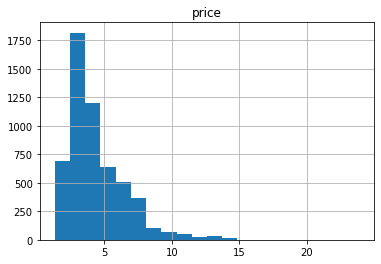

In [15]:
hh.hist(bins=20)

# Función de Distribucion Normal

En teoría de probabilidad la función de distribución normal ó distribución gaussiana es una función que mide la densidad y dispersión de valores de una variable aleatoria y se expresa de la siguiente manera:

$
f(x) = \frac{1}{\sqrt{2 \pi}} e^{{-\frac{1}{2}}(\frac{x-\mu}{\sigma})^2}
$

Para ver como se comporta la función de distribución gaussiana, hice la siguiente gráfica interactiva en Desmos (https://www.desmos.com/calculator/5et00ms9jg) podemos variar esto parámetros de desplazamiento (b) y anchura (c), considerando a = 1. Donde $a$ es la altura de la campana, $b$ es para desplazar a la curva a lo largo del eje x, y $c$ es la desviación estandar ó anchura. 

$
f(x) = ae^{\frac{-(x-b)^2}{2c}}
$




La idea principal es crear números aleatorios que respeten la distribución normal del índice ```henry hub```. Podemos hacer uso de la función de la librería ```numpy```llamada ```np.random.normal()```. A la cual debemos de proveerles tres argumentos, el parámetro $\mu$ (Expectation Value), el parámetro $\sigma$ que representa la desviación estandár de nuestra variable y por último, debemos definir la cantidad de números aleatorios a generar (252 por año, equivalentes a los dias de trading en un año). El siguiente código muestra como utilizar esta función de numpy para generar 1000 números aleatorios con un desviación de 1 y centrada en 20 (eje x)

(array([  6.,  17.,  72., 148., 206., 230., 169.,  97.,  49.,   6.]),
 array([16.90021504, 17.48889195, 18.07756887, 18.66624579, 19.2549227 ,
        19.84359962, 20.43227654, 21.02095345, 21.60963037, 22.19830728,
        22.7869842 ]),
 <a list of 10 Patch objects>)

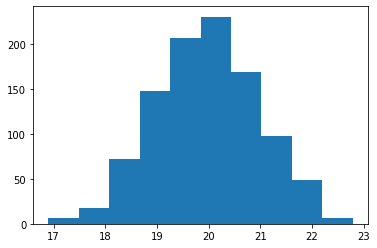

In [16]:
#Ejemplo de distribución normal con numpy.random.normal()

values = np.random.normal(loc=20    # Grafica centrada en el valor 20 del eje x
                         ,scale=1   # Anchura, Extiende la campana por el eje x
                         ,size=1000 # 1000 samples
                         )
plt.hist(values)

El valor de expectación ($\mu$), se calcula obteniendo primero la tasa de crecimiento anual compuesto y dividiendola entre 252 (dias disponibles del año para hacer trading) para obtener el promedio diario

$
CAGR(t_0,t_n) = \frac{V(t_n)}{V(t_0)}^{\frac{1}{t_n-t_0}} -1
$

donde:

$t_n - t_0$ Representa la cantidad de periodos dados en años

$V(t_n)$ Es el último valor registrado (Valor actual)

$V(t_0) $ Es el primer valor registrado

Necesitamos conocer el número de años (periodos) transcurridos desde el primer precio registrado y el último registrado


In [17]:
num_dias = (hh.index[-1] - hh.index[0]).days
num_años = num_dias/365
Vtn = hh['price'][-1]
Vt0 = hh['price'][1]  
print("Número de años :", int(num_años))

Número de años : 22


In [18]:
cagr = ((Vtn/Vt0)**(1/num_años)) - 1
print ('CAGR =',str(round(cagr,5)*100)+"%")

CAGR = 2.491%


Finalmente tenemos que $\mu = 0.000098$.

In [19]:
T = 252
mu = cagr/T
print("El valor mu es", mu)

El valor mu es 9.884383415831663e-05


Creamos una nueva columna en donde aplicaremos el método ```.pct_change()``` para obtener la tasa de retorno de Henry Hub. Vamos a generar números aleatorios en función a las tasas de retorno.

$
Retorno = \frac{V(t_n)}{V(t_{n-1})} - 1
$

In [20]:
hh['returns'] = hh['price'].pct_change()
hh.returns

date
2000-01-04         NaN
2000-01-05    0.004630
2000-01-06    0.004608
2000-01-07    0.004587
2000-01-10    0.004566
                ...   
2021-12-29    0.024096
2021-12-30    0.123529
2021-12-31    0.000000
2022-01-03   -0.020942
2022-01-04   -0.002674
Name: returns, Length: 5538, dtype: float64

Podemos obtener la desviación $\sigma$ mediante el metodo ```.std()```. Este valor describe la anchura de la campana, o que tanto se dispersan los valores de mi variable aleatoria por el eje x

In [21]:
dev = hh['returns'].std()
print ("Desviación =",str(round(dev,4)))

Desviación = 0.054


Ya tenemos todo lo necesario para empezar a generar nuestros números aleatorios. En este segmento crearemos una sola serie aleatoria de precios HHub

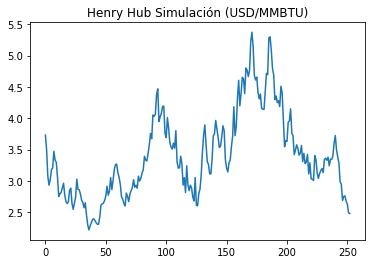

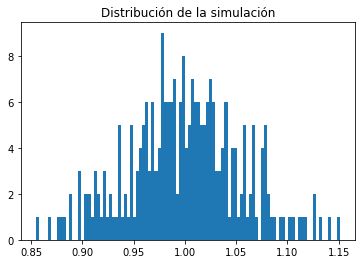

In [22]:
daily_returns = np.random.normal(loc= mu,   # valor x al que esta centrada la campana
                               scale= dev,  # desviación (sigma)
                               size= T) + 1 # +1 Porque se multiplica con el último valor registrado

# Inicializamos la simulación con el último precio registrado de HHub
price_list = [Vtn]
for x in daily_returns:
  # Multiplicamos el ultimo valor de la lista por el retorno diario aleatorio
  # y concatenamos el valor obtenido en la lista, de esta manera 
  # generamos series aleatorias en funcion de la distribución de HH
    price_list.append(price_list[-1]*x) 
    
# Graficamos resultados
plt.plot(price_list)
plt.title('Henry Hub Simulación (USD/MMBTU)')
plt.show()
plt.hist(daily_returns, 100, ) 
plt.title('Distribución de la simulación')
plt.show()

Ahora solo debemos hacer el procedimiento una cantidad de $n$ veces. Realizaremos $10,000$ simulaciones

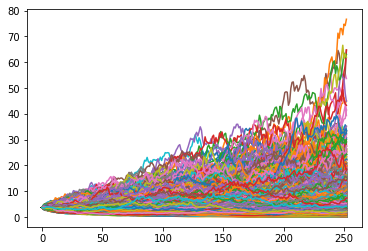

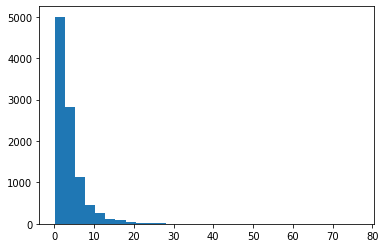

In [23]:
# lista vacia para almacenar nuestros valores finales de cada simulación
result = []

# cantidad de simulaciones
for i in range(10000):

    # creamos una serie de retornos aleatorios
    daily_returns=np.random.normal(mu,dev,T)+1
    
    # inicializamos con el ultimo precio registrado de HHub
    price_list = [Vtn]
    
    # multiplicamos el ultimo valor registrado con el retorno aleatorio
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # graficamos
    plt.plot(price_list)
    
    # almacenamos el ultimo valor en la lista de resultados
    result.append(price_list[-1])
    
# mostramos la grafica final
plt.show()

# histograma de la lista de resultados
plt.hist(result,bins=30)
plt.show()

Finalmente, observamos los resultados de nuestras simulaciones. 

In [24]:
print("Promedio     =",round(np.mean(result),4))
print("5% quantile  =",round(np.percentile(result,5),5))
print("25% quantile =",round(np.percentile(result,25),5))
print("50% quantile =",round(np.percentile(result,50),5))
print("75% quantile =",round(np.percentile(result,75),5))
print("95% quantile =",round(np.percentile(result,95),5))

Promedio     = 3.8629
5% quantile  = 0.64904
25% quantile = 1.49227
50% quantile = 2.62015
75% quantile = 4.72406
95% quantile = 11.08919
